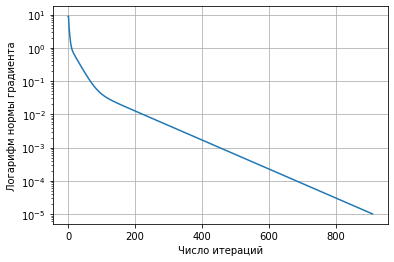

In [10]:
# Градиентный спуск с постоянным шагом

import numpy as np
import math
import random
import matplotlib.pyplot as plt

N = 10 
eps = 10**(-5)

U = np.random.sample((N, N))
Q = np.linalg.qr(U)[0]
D = np.zeros((N, N))
for i in range(N):
    D[i][i] = i + 1
A = ((Q.transpose()).dot(D)).dot(Q)
b = np.random.sample(N)
x = np.zeros(N)

M = (A.transpose()).dot(A)
d = (A.transpose()).dot(b)

h = 1/max(np.linalg.eigvals(M))

r = []
g = M.dot(x) - d
norm = np.linalg.norm(g)
while norm > eps:
    r.append(norm)
    g = M.dot(x) - d
    norm = np.linalg.norm(g)
    x = x - h*g
    
fig, ax = plt.subplots()
ax.semilogy(r)

ax.set(xlabel='Число итераций', ylabel='Логарифм нормы градиента')
ax.grid()
fig.savefig("test1.eps")

In [5]:
x - np.linalg.solve(A, b)

array([ 1.01358153e-06, -5.58532896e-06, -1.82506126e-06, -3.31253972e-06,
        4.82598365e-07, -2.87189991e-06, -9.17695315e-07, -1.92478257e-06,
       -5.82177787e-06,  1.72697361e-06])

In [6]:
x

array([0.0445736 , 0.5142015 , 0.43564827, 0.19546946, 0.04248388,
       0.22552414, 0.20246178, 0.31616286, 0.38850583, 0.24115803])

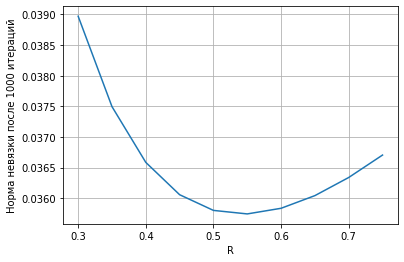

In [11]:
# Переход к композитной оптимизации + децентрализация
sol = np.linalg.solve(A, b)

def test_R(R):
    X = np.zeros(N*N)

    L = -np.ones((N, N))
    for i in range(N):
        L[i][i] += N
    W = np.kron(L, np.eye(N))

    err = []

    for i in range(1000):
        current_err = []
        for j in range(N):
            cW = W[::,N*j:N*j+N]
            aTa = np.array([[A[j][p]*A[j][q] for p in range(N)] for q in range(N)])
            eigv = [abs(i) for i in np.linalg.eigvals(aTa + R*(cW.transpose()).dot(cW))]
            h = 1/max(eigv)
            grad = aTa.dot(X[N*j:N*j+N]) + R*(cW.transpose()).dot(W.dot(X)) - b[j]*A[j]
            X[N*j:N*j+N] = X[N*j:N*j+N] - h*grad
            current_err.append(np.linalg.norm(X[N*j:N*j+N] - sol))
        err.append(max(current_err))
    return err[-1]

err1 = []
R1 = []
for i in range(10):
    R = 0.3 + 0.05*i 
    R1.append(R)
    err1.append(test_R(R))
    
fig, ax = plt.subplots()
ax.plot(R1, err1)

ax.set(xlabel='R', ylabel='Норма невязки после 1000 итераций')
ax.grid()
fig.savefig("test2.eps")

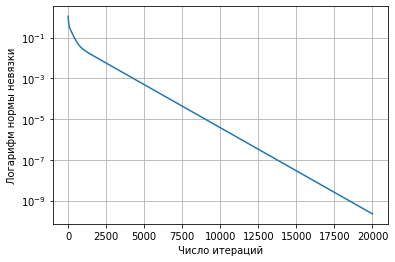

In [12]:
sol = np.linalg.solve(A, b)
R = 0.5
X = np.zeros(N*N)

L = -np.ones((N, N))
for i in range(N):
    L[i][i] += N
W = np.kron(L, np.eye(N))

err = []
err_WX = []

aTa_list = [np.array([[A[j][p]*A[j][q] for p in range(N)] for q in range(N)]) for j in range(N)]

for i in range(20000):
    current_err = []
    for j in range(N):
        cW = W[::,N*j:N*j+N]
        aTa = aTa_list[j]
        eigv = np.linalg.eigvals(aTa + R*(cW.transpose()).dot(cW))
        eigv = [abs(i) for i in eigv]
        h = 1/max(eigv)
        grad = aTa.dot(X[N*j:N*j+N]) + R*(cW.transpose()).dot(W.dot(X)) - b[j]*A[j]
        X[N*j:N*j+N] = X[N*j:N*j+N] - h*grad
        current_err.append(np.linalg.norm(X[N*j:N*j+N] - sol))
    err.append(max(current_err))
    err_WX.append(np.linalg.norm(W.dot(X)))
fig, ax = plt.subplots()
ax.semilogy(err_WX)

ax.set(xlabel='Число итераций', ylabel='Логарифм нормы невязки')
ax.grid()
fig.savefig("test3.eps")

In [259]:
[err[i] - err_WX[i] for i in range(100)]

[-0.14557537588169822,
 -0.12118586277617371,
 -0.10841768062678081,
 -0.09704064964611003,
 -0.08666328075173269,
 -0.07712371326444922,
 -0.06830895380501989,
 -0.060129469234381006,
 -0.05251047621218008,
 -0.04538847591037931,
 -0.038709249688340774,
 -0.032394873480268704,
 -0.026427855618777585,
 -0.020785383925003842,
 -0.015437763840278729,
 -0.010359283020114685,
 -0.005527591827797829,
 -0.0009231823546439477,
 0.003471049501097556,
 0.007670171865877151,
 0.011687525626663864,
 0.015534983412861969,
 0.019223166755271248,
 0.02276162814109539,
 0.02615900364391699,
 0.029423140917753332,
 0.032561206585721814,
 0.035579776409353725,
 0.038484911078638606,
 0.04128222000163917,
 0.04397691508369128,
 0.04657385615907994,
 0.0490775894633273,
 0.05149238030381109,
 0.05382224089344434,
 0.05607095415071872,
 0.058242094134511535,
 0.06033904366944398,
 0.062365009623679524,
 0.06432303622277946,
 0.06621601671810462,
 0.06804670367404175,
 0.06981771809330173,
 0.0715315575621